# Using `enterprise` to search for an isotropic stochastic gravitational wave background with one pulsar

In this notebook you will learn:
* How to use `enterprise` to interact with NANOGrav data,
* How to search a single pulsar for a common red noise process,
* How to use the Savage-Dickey approximation to estimate a Bayes factor.

# Load packages and modules

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps

from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals import white_signals
from enterprise.signals import gp_signals

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

import sys
sys.path.append("..")
from settings import fd_bins

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
# set the data directory
datadir = '../data'
if not os.path.isdir(datadir):
    datadir = '../../data'
print(datadir)

../../data


## Picking a pulsar
* For this analysis, we will use pulsar J1909. We have picked this one because of its total observation time, and because in the 12.5 year stochcastic gravitational wave background (SGWB) search it has a large dropout factor, meaning that it prefers the model with a common red noise process over the model with intrinsic red noise only.

* You are welcome to change this to any pulsar listed in the data folder. Sampling in the single pulsar case will likely take on the order of ~1 hour. We have included samples for J1909, so sampling is optional.

In [3]:
# get only J1909
psrname = 'J1909'
parfiles = sorted(glob.glob(datadir + '/par/' + psrname + '*par'))
timfiles = sorted(glob.glob(datadir + '/tim/' + psrname + '*tim'))

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]
print(parfiles)
print(timfiles)

['../../data/par/J1909-3744_NANOGrav_12yv3.gls.par']
['../../data/tim/J1909-3744_NANOGrav_12yv3.tim']


## Load in Pulsar class list
* The `enterprise` Pulsar class uses `libstempo` (or optionally `PINT`) to read in `par` and `tim` files, then stores all pulsar data into a `Pulsar` object. This object contains all data and meta-data needed for the ensuing pulsar and PTA analysis. You no longer need to reference the `par` and `tim` files after this cell.
* Note below that you can explicitly declare which version of the JPL solar-system ephemeris model that will be used to compute the Roemer delay between the geocenter and the barycenter (e.g. `DE438`). Otherwise the default values will be taken from the `par` files. Explicitly declaring the version here is good practice.

In [4]:
psrs = []
ephemeris = 'DE438'
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

[tempo2Util.C:396] Warning: [MISC1] Unknown parameter in par file:  DMX
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.

[tempo2Util.C:396] Warning: [PAR2] Have not set a DM epoch. The period epoch will be used instead. ../par/J1909-3744_NANOGrav_12yv3.gls.par
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[observatory.C:267] Warning: Assuming site '1' means 'gbt'


### Look at the data
* As a quick aside, we can look at the time of arrivals and residuals by using the `Pulsar` class
* This object contains some other useful objects such as the timing model design matrix (`Mmat`)

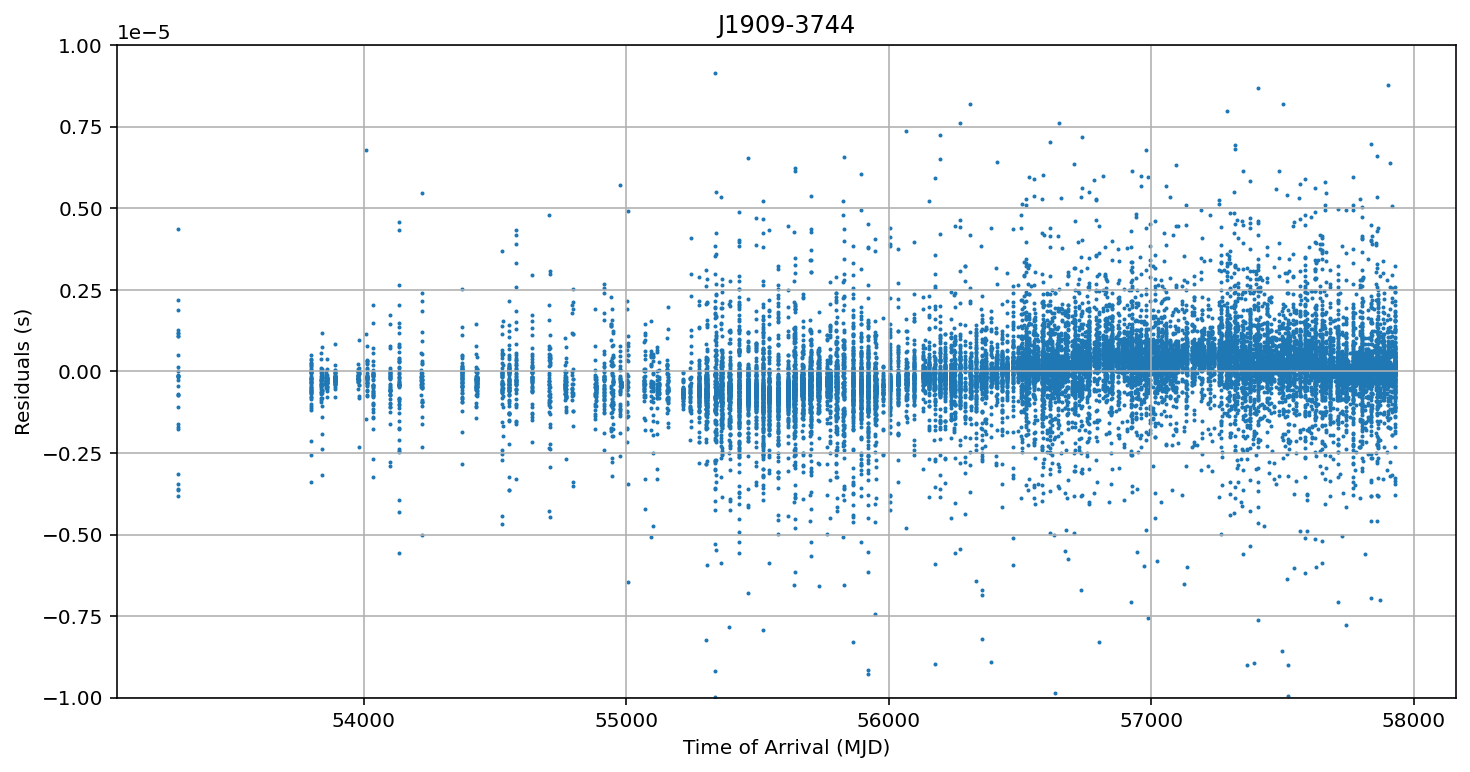

In [5]:
psr = psrs[0]
plt.figure(figsize=(12, 6))
plt.scatter(psr.toas / 86400, psr.residuals, s=1)
plt.title(psr.name)
plt.xlabel('Time of Arrival (MJD)')
plt.ylabel('Residuals (s)')
plt.ylim([-1e-5, 1e-5])
plt.grid(b=True)
plt.show()

* We can read-in some previously computed noise properties from single-pulsar white noise analyses. These are things like `EFAC`, `EQUAD`, and (for `NANOGrav`) `ECORR`. 
* In practice, we set these white-noise properties as fixed in the low-frequency noise / GW searches.
* See `singlepulsar_whitenoise_analysis.ipynb` to see an example script that can be used to find these values.
* The noise values have been stored as `json` files and are ready to load in to a dictionary.

### Get parameter noise dictionary

In [6]:
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

* In a full PTA analyses we fix all of the white noise (EFAC, EQUAD, and ECORR) parameters to the values obtained from the noise files. This is done by using `Constant` parameters. In this case we do not specify a default value for all instances of that parameter but instead will set them, based on their initialized pulsar and backend specific name later via the `set_default_params` method of `PTA`.

* For a single pulsar, it is not necessary to set the white noise as constant, but the computation time will increase with the increase in number of parameters. For this notebook, we set it as constant.

* We use the `Selection` object to define which noise parameters are assigned to which chunks of TOAs. This selection is based on unique combination of backends and receivers.

### Define selection by observing backend

In [7]:
selection = selections.Selection(selections.by_backend)

## Pulsar Model

* Now we're ready to start creating the model!

In [8]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

### Priors
* For this **detection** search, we will use a `Uniform` prior on both the log of the intrinsic and common red noise, and set the white noise parameters as `Constant` with values added in later from the noise dictionary.

* In the single pulsar case, a varying spectral index (gamma) would be completely covariant with the intrinsic red noise, so we fix it here to 13/3 ~ 4.33.

In [9]:
# white noise parameters
efac = parameter.Constant()
equad = parameter.Constant()
ecorr = parameter.Constant() # we'll set these later with the params dictionary

# red noise parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.Uniform(-18, -12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

### Signals

* Now we attach the priors above to signal objects. These objects can be added together to create the full model which can operate on each pulsar resulting in the full PTA object.
* Notice that the number of common process components here is changed to line up with the search in the full PTA search
* We do this by setting `components=5` in `FourierBasisGP`

In [10]:
# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations with 5 frequencies)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=5, Tspan=Tspan, name='gw')

# timing model
tm = gp_signals.TimingModel(use_svd=True)

## Create the full model

In [11]:
s = ef + eq + ec + rn + tm + gw

In [12]:
# intialize PTA (this cell will take ~30s to run)
models = []

for p in psrs:    
    models.append(s(p))

pta = signal_base.PTA(models)

In [13]:
# set white noise parameters with dictionary imported earlier
pta.set_default_params(params)

## Sampling

* Now we need to sample the posterior!
* `PTMCMCSampler` is a parallel tempering Metropolis-Hastings sampler with adaptive jump proposals.
* This means that the sampler will take in the log-likelihood and the log-prior and return samples from the posterior.
* By using additional cores with MPI, we can activate the parallel tempering part of `PTMCMCSampler`, but this is not covered in this tutorial.
* `PTMCMCSampler` has been used for several years with NANOGrav data, and it is tuned quite well to sample from these types of posteriors even with high numbers of dimensions.
* The initial jump covariance matrix is used in adaptive jump proposals in `PTMCMCSampler` - we will not cover this in these tutorials

In [14]:
# set initial parameters drawn from prior
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

In [15]:
# set up the sampler:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

outDir = '../../gwanw_sngl_chains/'

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov,
                 outDir=outDir, resume=False)

### Sampler for N steps
* We have included chains so that you do not need to sample yourself
* Uncomment the last line if you would like to sample the posterior yourself
* Sampling can take a very long time (but probably will not in the single pulsar case)

In [16]:
N = int(1e6)
x0 = np.hstack([p.sample() for p in pta.params])
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [17]:
# Uncomment this one to load the chain if you have sampled above with PTMCMCSampler:
# chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))

# This will load the chain that we have provided:
chain = np.load(os.path.join(outDir, 'chain_1.npz'))['arr_0']

burn = int(0.25 * chain.shape[0])  # remove burn in segment of sampling

In [18]:
ind = list(pta.param_names).index('log10_A_gw')

### Make trace-plot to diagnose sampling
* We want this to look like a fuzzy caterpillar and not like a skinny worm!
* It is a good idea to make sure that the sampler appears "burned-in"
* That means that the sampler is not wildly searching for the distribution and looks stationary

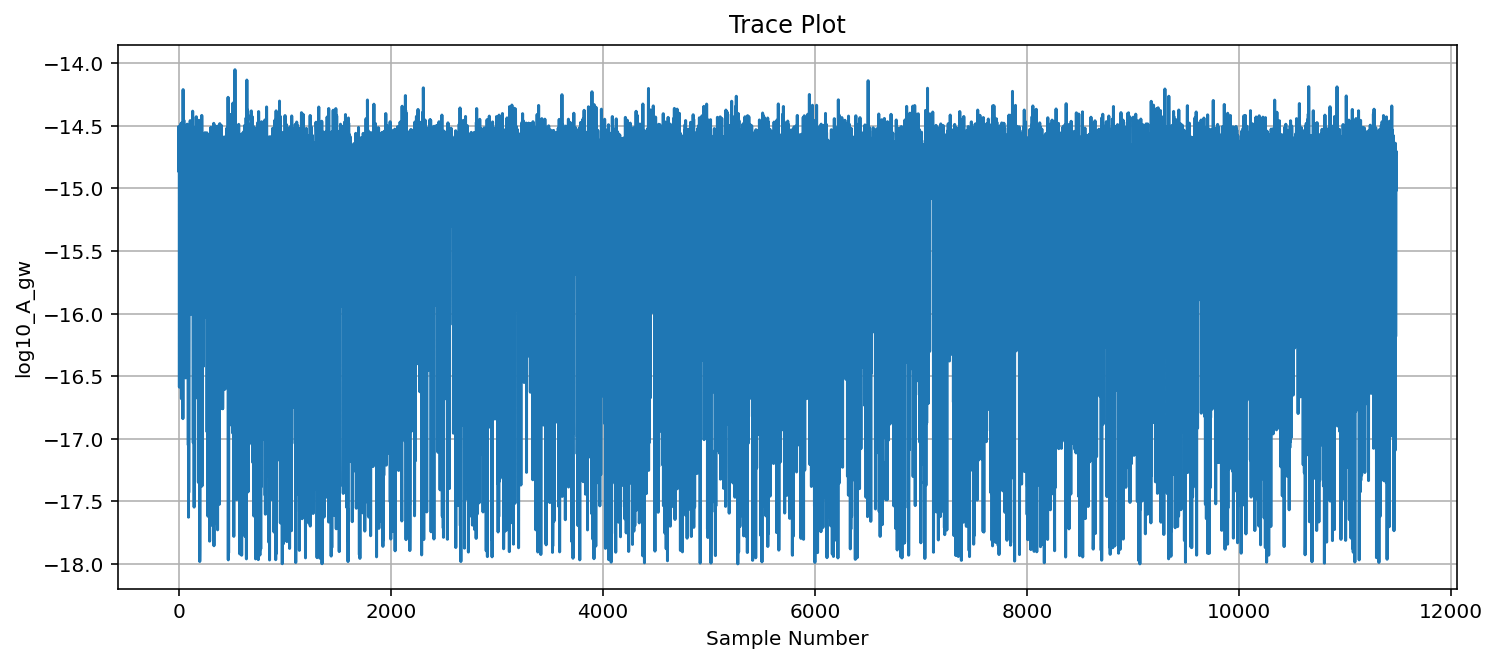

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(chain[burn:, ind])
plt.xlabel('Sample Number')
plt.ylabel('log10_A_gw')
plt.title('Trace Plot')
plt.grid(b=True)
plt.show()

### Plot a histogram of the marginalized posterior distribution
* Here we can check out what the marginalize posterior for $log_{10}A_{gw}$ looks like!


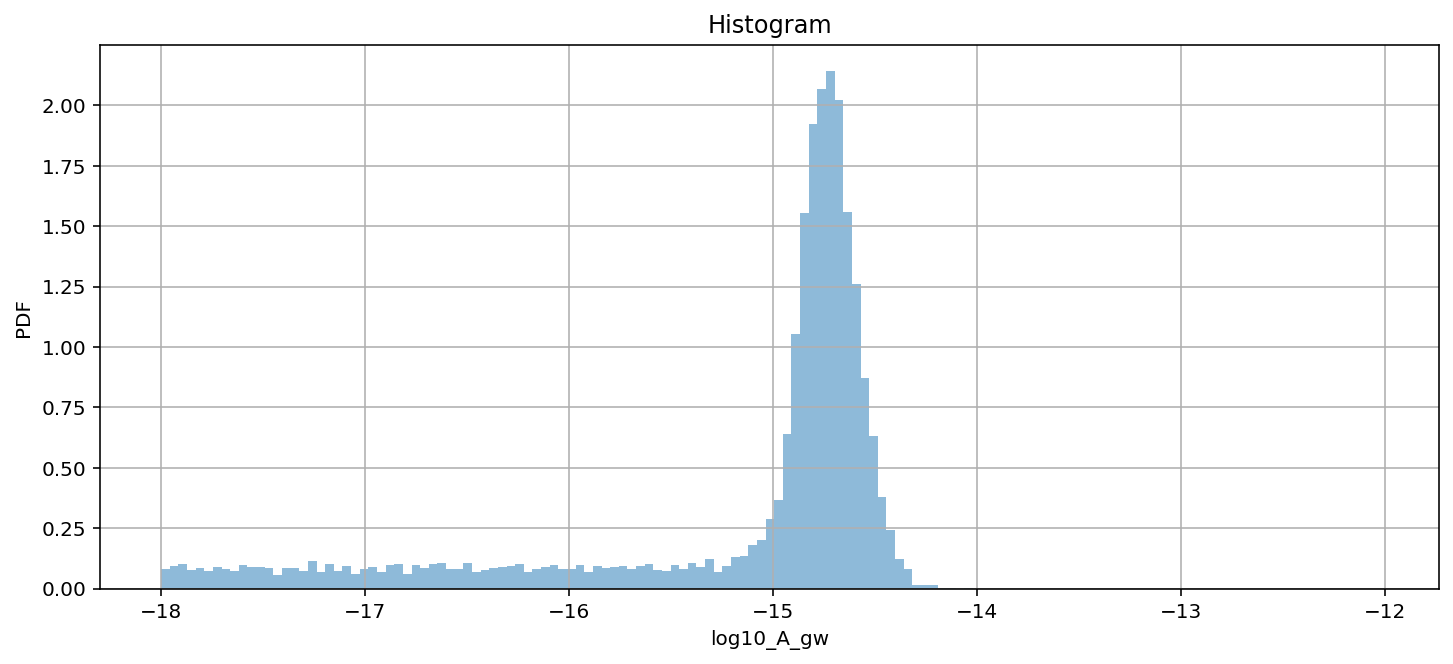

In [20]:
bins = fd_bins(chain[burn:, ind], logAmin=-18, logAmax=-12)  # let FD rule decide bins (in ../settings.py)
plt.figure(figsize=(12, 5))
plt.title('Histogram')
plt.hist(chain[burn:,ind], bins=bins, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5, density=True)
plt.xlabel('log10_A_gw')
plt.ylabel('PDF')
plt.grid(b=True)
plt.show()

In [21]:
hist = np.histogram(chain[burn:, ind],
                    bins=bins,
                    density=True)
max_ind = np.argmax(hist[0])
print('Our max =', hist[1][max_ind])  # from our computation

Our max = -14.741102466268078


## Discussion

* The posterior shows that this pulsar prefers a common red process. We can see this by examining the left side of the plot. There is still a tail that exists and extends out to the lower limit of our prior that has shown up in the posterior, so the common red noise process is not *strongly* preferred. We can quantify this by finding the Bayes factor between a model with and without a common red noise process.
* The file included with these tutorials that shows the most likely values from the 12.5 year SGWB search, `12p5yr_maxlike.json`, shows `gw_log10_A` = -14.78
* Our maximum is pretty close to what was found in the single pulsar, `J1909` analysis at `gw_log10_A` = -14.74

## Savage Dickey Approximation for Bayes factor
* As long as the posterior has a tail that extends to the lower limit of the prior with enough samples, we can compare that tail with the prior to compute a quick Bayes factor between two models differing in one parameter by taking the limit as that parameter goes to zero.
* To do this, we make our own function which will divide the prior by the posterior in the limit as $\log_{10}A_{gw} \rightarrow 0$.
* For more information, see Section 6.3.5 in [The Nanohertz Gravitational Wave Astronomer](https://arxiv.org/pdf/2105.13270.pdf) by Steve R. Taylor

In [24]:
pta.params  # check the pmin and pmax values on log10_A_gw

[J1909-3744_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J1909-3744_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 log10_A_gw:Uniform(pmin=-18, pmax=-12)]

In [25]:
log10Amax = -12
log10Amin = -18
prior = 1 / (log10Amax - log10Amin)  # uniform-in-log prior
x = np.linspace(-18, -16, 100)  # samples to average over
rv_hist = sps.rv_histogram(hist)
post = np.mean(rv_hist.pdf(x))

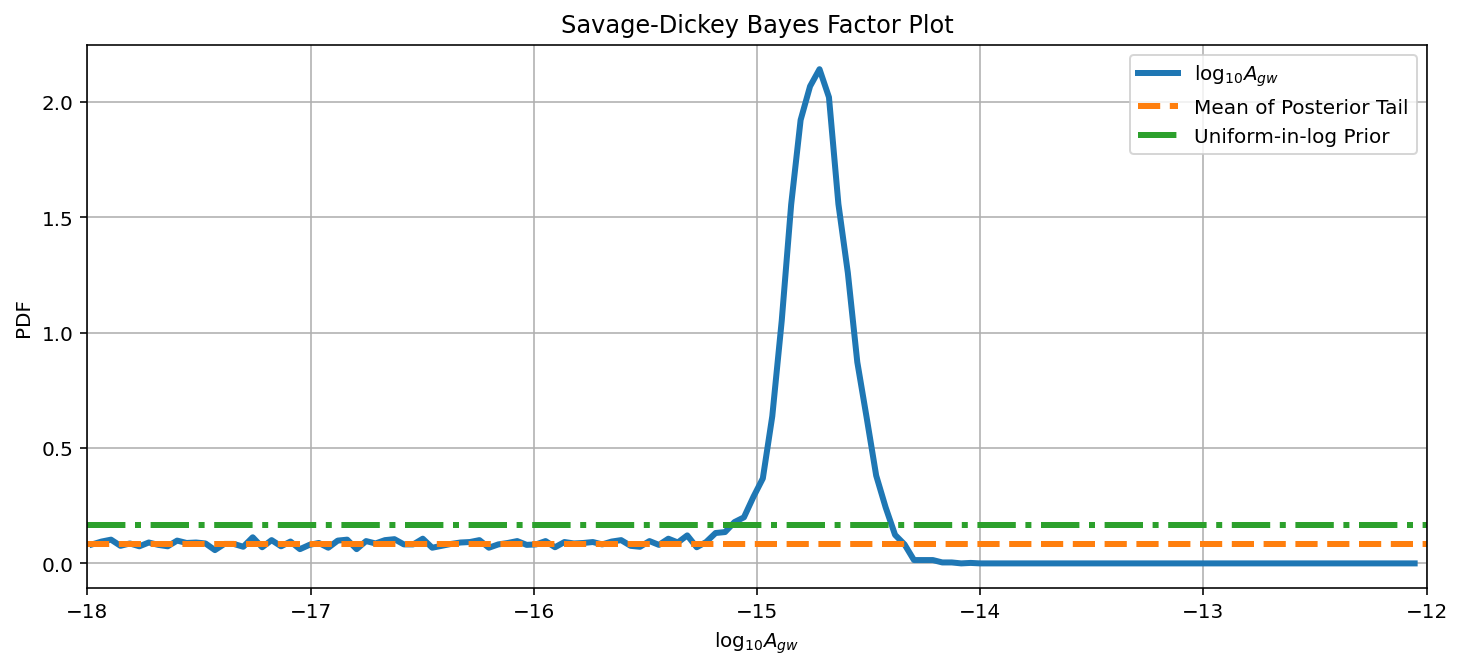

In [30]:
plt.figure(figsize=(12, 5))
plt.plot((hist[1][:-1] + hist[1][1:]) / 2, hist[0], label=r'$\log_{10}A_{gw}$', color='C0', lw=3)
plt.axhline(post, label='Mean of Posterior Tail', color='C1', ls='--', lw=3)
plt.axhline(prior, label='Uniform-in-log Prior', color='C2', ls='-.', lw=3)
plt.xlim([-18, -12])
plt.xlabel(r'$\log_{10}A_{gw}$')
plt.ylabel('PDF')
plt.title('Savage-Dickey Bayes Factor Plot')
plt.legend()
plt.grid(b=True)
plt.show()

In [31]:
# Compute Bayes factor!
prior / post

1.9442656900288666

* The posterior has reduced to ~1/2 the value of the prior
* So this model with a common red process is preferred by J1909 over the model with intrinsic red noise only with a BF = 1.94
* Notice that the two models that were compared with the Savage-Dickey approximation were only different in this one parameter

### Remarks

* J1909 alone appears to prefer the common red process, but in order to build up the Bayes factor, we need to add in more pulsars.